In [2]:
import pandas as pd
import numpy as np

In [ ]:
# Using GPU to run model 
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
# Read and process the text column for the task
df_train = pd.read_csv("trac2_CONVT_train.csv")
convoColumn = df_train["text"]
print(convoColumn)

0                    what did you think about this article
1        It's definitely really sad to read, considerin...
2        I think it's super sad... they seem to never c...
3        I can't imagine just living in an area that is...
4        Me too.. I also can't imagine living in the po...
                               ...                        
11085      Do you think maybe he was force to kill himself
11086                          I think somebody killed him
11087    Or he could have slipped on something. Either ...
11088    I don't know if he was nice or not. It was nic...
11089                                   ok thank you. bye!
Name: text, Length: 11090, dtype: object


In [ ]:
# Importing and using SentenceTransformer for transforming sentences into 384 dimensional vector
# Input: Sentence from the training text
# Output: The vector representation of the sentence, which is X_train for the model


from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
X_train = model.encode(convoColumn, device = device)
print(len(X_train[0])) # Dimension of the vector (384 with this model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

384


In [ ]:
# This cell build the output (Y_output) for any dataframe
# Output of regression task: Emotion Intensity (From 0-5 in ordinal scale) and Emphathy Intensity (0-5 in ordinal scale)
# Output of classficiation task: Emotional Polarity (0, 1, 2). 0 is positive, 1 is neutral and 2 is negative
from numpy import unique

def processOutput(df):
    emotionColumnIndex = df.columns.get_loc("Emotion")
    emotionPolarityColumnIndex = df.columns.get_loc("EmotionalPolarity")
    emphathyColumnIndex = df.columns.get_loc("Empathy")

    Y_reg = []
    Y_class = []
    instance = []

    for i in range(0, len(df)):
        instance.append(df.iloc[i, emotionColumnIndex])
        instance.append(df.iloc[i, emphathyColumnIndex])
        Y_reg.append(instance)
        instance = []

    for i in range(0, len(df)):
        instance.append(df.iloc[i, emotionPolarityColumnIndex])
        Y_class.append(instance)
        instance = []

    return np.array(Y_reg), np.array(Y_class)

Y_train_reg, Y_train_class = processOutput(df_train)
nClass = len(unique(Y_train_class))

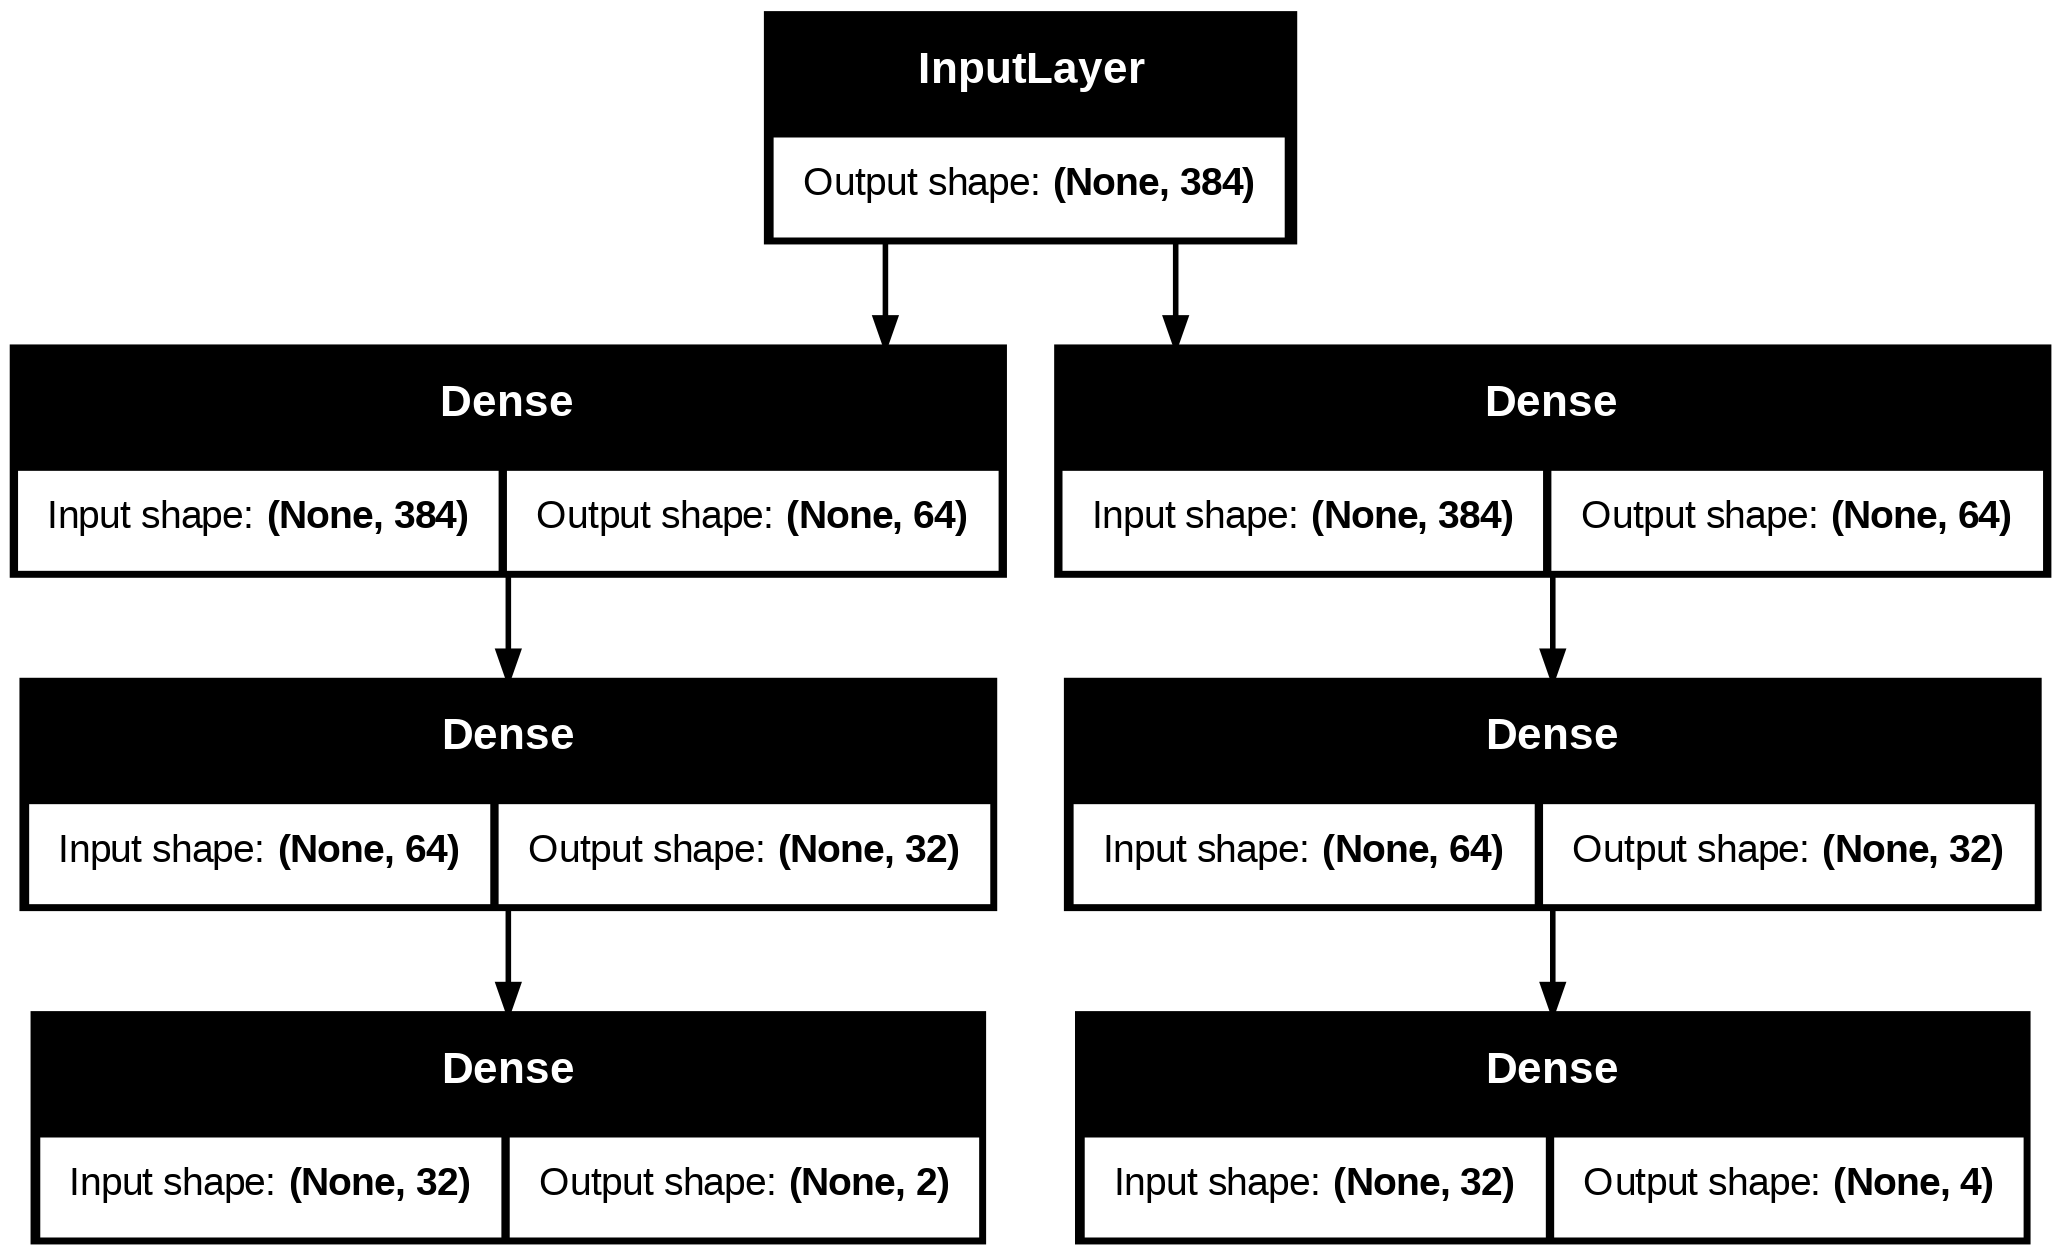

In [ ]:
# Main model for both the regression and classification task

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

tf.random.set_seed(42)

# Input layer 
inputs= Input(shape = (384,))

# First regression layers with batch normalization + dropout
x1Regression = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(inputs)
BatchNormalization()(x1Regression)
Dropout(0.2)(x1Regression)

# Second regression layers with batch normalization + dropout
x2Regression = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x1Regression)
BatchNormalization()(x2Regression)
Dropout(0.2)(x2Regression)

# Regression output layers
regression_output = Dense(2, name='regression')(x2Regression)

# First classification layers with batch normalization + dropout
x1Classfication = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(inputs)
BatchNormalization()(x1Classfication),
Dropout(0.2)

# Second classification layers with batch normalization + dropout
x2Classification = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x1Classfication)
BatchNormalization()(x2Classification),
Dropout(0.2)

# Classification output layers
classification_output = Dense(nClass, activation = 'softmax', name='classification')(x2Classification)

# Model Constructors
modelNLP = Model(inputs = inputs, outputs=[regression_output, classification_output])

# Model comppile parameter
modelNLP.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'regression': 'mse',
        'classification': 'categorical_crossentropy'
    },
    metrics={
        'regression': ['mse'],
        'classification': ['accuracy']
    }
)

# Plot model architecture
plot_model(modelNLP, to_file='model.png', show_shapes=True)

In [ ]:
# Fit model
modelNLP.fit(
    X_train, [Y_train_reg, to_categorical(Y_train_class, num_classes = nClass)],
    epochs=30,
    batch_size=32,
    validation_split=0.2
)

# Save model 
modelNLP.save("ANNModel.keras")

Epoch 1/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - classification_accuracy: 0.5235 - classification_loss: 1.0270 - loss: 3.2015 - regression_loss: 1.9024 - regression_mse: 1.9024 - val_classification_accuracy: 0.6596 - val_classification_loss: 0.7234 - val_loss: 1.5574 - val_regression_loss: 0.6378 - val_regression_mse: 0.6409
Epoch 2/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - classification_accuracy: 0.6710 - classification_loss: 0.7089 - loss: 1.4012 - regression_loss: 0.5139 - regression_mse: 0.5139 - val_classification_accuracy: 0.6524 - val_classification_loss: 0.7159 - val_loss: 1.4603 - val_regression_loss: 0.5944 - val_regression_mse: 0.5978
Epoch 3/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - classification_accuracy: 0.6750 - classification_loss: 0.6904 - loss: 1.3073 - regression_loss: 0.4771 - regression_mse: 0.4771 - val_classification_accuracy: 0.6555 - val_classification_loss: 0.7147 - val_loss: 1.4305 - val_regression_loss: 0.5880 - val_regression_mse: 0.5915
Ep

In [ ]:
# Building X_test and Y_test

df_test = pd.read_csv("trac2_CONVT_dev.csv")
df_test["EmotionalPolarity"] = np.ceil(df_test['EmotionalPolarity'])

convoColumnTest = df_test["text"]
X_test = model.encode(convoColumnTest, device = device)

Y_test_reg, Y_test_class = processOutput(df_test)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE per output: [0.42055665 0.8402252 ]
RMSE per output: [0.64850339 0.91663799]
MAE per output: [0.50643605 0.75351281]
[[ 63  79  15]
 [ 25 337  87]
 [  4 131 249]]


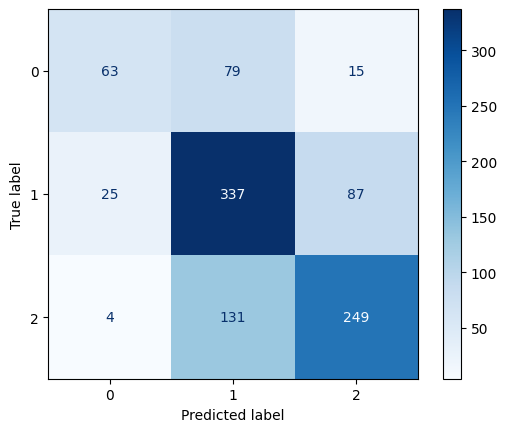

0.663176289233439 0.6555555555555556 0.6499664044758708 0.6555555555555556


In [ ]:
# Predict Y_pred and compare with Y_test, and build confusion matrix as well as compute stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

modelNLP = load_model("ANNModel.keras")

y_pred = modelNLP.predict(X_test)
y_reg_pred = y_pred[0]
y_class_pred = np.argmax(y_pred[1], axis=1)


mse = mean_squared_error(Y_test_reg, y_reg_pred, multioutput='raw_values')

rmse = np.sqrt(mse)

mae = mean_absolute_error(Y_test_reg, y_reg_pred, multioutput='raw_values')

cm = confusion_matrix(Y_test_class, y_class_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

precision = precision_score(Y_test_class, y_class_pred, average = "weighted")

recall = recall_score(Y_test_class, y_class_pred, average = "weighted")

f1 = f1_score(Y_test_class, y_class_pred, average = "weighted")

accuracy = accuracy_score(Y_test_class, y_class_pred)

print("MSE per output:", mse)

print("RMSE per output:", rmse)

print("MAE per output:", mae)

print(f"Precision: {precision:.4f}")

print(f"Recall:    {recall:.4f}")

print(f"F1 Score:  {f1:.4f}")

print(f"Accuracy:  {accuracy:.4f}")

In [ ]:
# Infer and save the result into a new csv

df_infer = pd.read_csv("trac2_CONVT_test.csv")
textInfer = df_infer["text"]
ID = df_infer["id"]

X_infer = model.encode(textInfer, device = device)

y_infer = modelNLP.predict(X_infer)

y_reg_infer = y_infer[0]
y_class_infer = np.argmax(y_infer[1], axis=1)


df_pred = pd.DataFrame({
    "ID": ID,
    "Emotion": y_reg_infer[:, 0],
    "EmotionalPolarity": y_class_infer,
    "Empathy": y_reg_infer[:, 1]
})


df_pred.to_csv("predictions_ann.csv", index=False)

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
